# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

# SHAP
import shap

# Load dataset

In [2]:
df = pd.read_csv("D:\\TakeHomeTest\\DS\\Dataset\\Food_Delivery_Times.csv")

# Melihat 5 data teratas
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


# Data Understanding

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


**Feature Groups**
- **Order Characteristics:** Distance_km, Vehicle_Type
- **Environmental Factors:** Traffic_Level, Weather_Condition
- **Courier Factors:** Courier_Experience_yrs
- **Time Factors:** Order_Hour

## Missing Values

In [4]:
df.isnull().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

# Exploratory Data Analysis (EDA)

## 4.1 Target Variable Distribution

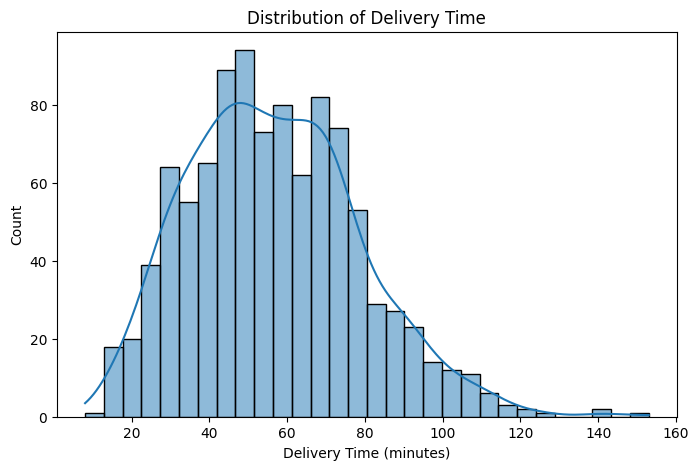

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df["Delivery_Time_min"], bins=30, kde=True)
plt.title("Distribution of Delivery Time")
plt.xlabel("Delivery Time (minutes)")
plt.show()

## 4.2 Distance vs Delivery Time

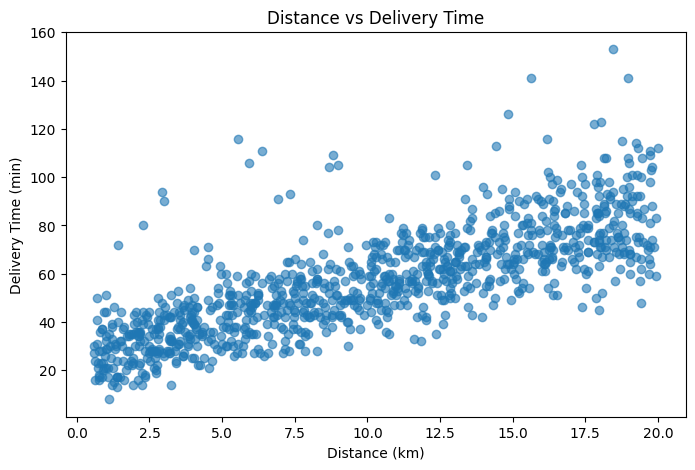

In [6]:
plt.figure(figsize=(8,5))
plt.scatter(df["Distance_km"], df["Delivery_Time_min"], alpha=0.6)
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (min)")
plt.title("Distance vs Delivery Time")
plt.show()

## 4.3 Traffic Level vs Delivery Time

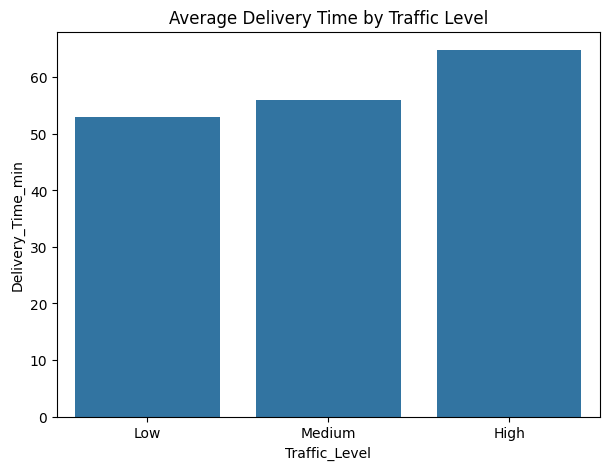

In [7]:
plt.figure(figsize=(7,5))
sns.barplot(x="Traffic_Level", y="Delivery_Time_min", data=df, errorbar=None)
plt.title("Average Delivery Time by Traffic Level")
plt.show()

## 4.4 Vehicle Type vs Delivery Time

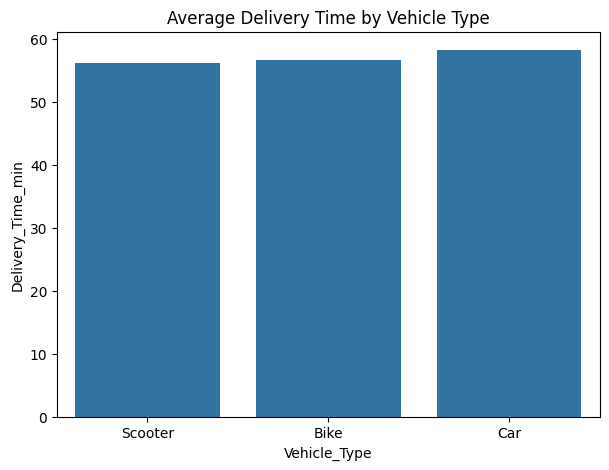

In [8]:
plt.figure(figsize=(7,5))
sns.barplot(x="Vehicle_Type", y="Delivery_Time_min", data=df, errorbar=None)
plt.title("Average Delivery Time by Vehicle Type")
plt.show()

## 4.5 Courier Experience vs Delivery Time

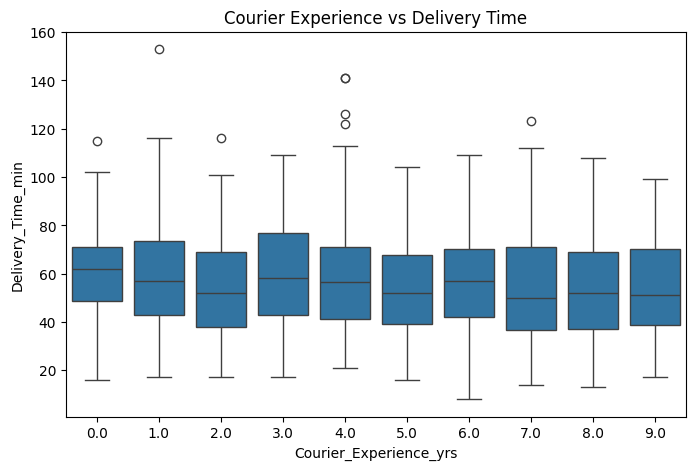

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Courier_Experience_yrs", y="Delivery_Time_min", data=df)
plt.title("Courier Experience vs Delivery Time")
plt.show()

# Feature Engineering

**Purpose**

Feature engineering is applied to capture **non-linear delivery behavior** and **operational realities** that are not directly represented in raw features.

## Distance Category (Non-linear Effect)

In [10]:
df['Distance_Category'] = pd.cut(
df['Distance_km'],
bins=[0,3,7,12,20],
labels=['Very_Near','Near','Medium','Far']
)

## Peak Hour Indicator

In [11]:
peak_hours = ['Morning','Evening']
df['Is_Peak_Hour'] = df['Time_of_Day'].isin(peak_hours).astype(int)

## Courier Experience Level

In [12]:
df['Experience_Level'] = pd.cut(
df['Courier_Experience_yrs'],
bins=[-1,2,5,10],
labels=['Junior','Mid','Senior']
)

## Distance × Traffic Interaction

In [13]:
traffic_weight = {'Low':1.0,'Medium':1.3,'High':1.6}
df['Distance_x_Traffic'] = df['Distance_km'] * df['Traffic_Level'].map(traffic_weight)

## Preparation Time × Peak Hour

In [14]:
df['Prep_x_Peak'] = df['Preparation_Time_min'] * df['Is_Peak_Hour']

**Feature Engineering Summary**

These engineered features allow the model to better capture congestion risk, courier skill segmentation, and compounding delay effects.

In [15]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Distance_Category,Is_Peak_Hour,Experience_Level,Distance_x_Traffic,Prep_x_Peak
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43,Medium,0,Junior,7.930,0
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84,Far,1,Junior,21.346,20
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59,Medium,0,Junior,9.520,0
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37,Medium,0,Junior,9.672,0
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68,Far,1,Mid,19.030,16


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Order_ID                1000 non-null   int64   
 1   Distance_km             1000 non-null   float64 
 2   Weather                 970 non-null    object  
 3   Traffic_Level           970 non-null    object  
 4   Time_of_Day             970 non-null    object  
 5   Vehicle_Type            1000 non-null   object  
 6   Preparation_Time_min    1000 non-null   int64   
 7   Courier_Experience_yrs  970 non-null    float64 
 8   Delivery_Time_min       1000 non-null   int64   
 9   Distance_Category       1000 non-null   category
 10  Is_Peak_Hour            1000 non-null   int64   
 11  Experience_Level        970 non-null    category
 12  Distance_x_Traffic      970 non-null    float64 
 13  Prep_x_Peak             1000 non-null   int64   
dtypes: category(2), float64(3

# 5. Data Preprocessing

## 5.1 Drop Irrelevant Columns

In [17]:
df = df.drop(columns=["Order_ID"])

## 5.2 Split Feature & Target

In [18]:
X = df.drop("Delivery_Time_min", axis=1)
y = df["Delivery_Time_min"]

## 5.3 Train-Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## 5.4 Handle Missing Values

In [20]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

for col in num_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

In [21]:
cat_cols = X_train.select_dtypes(include=["object"]).columns

for col in cat_cols:
    mode_val = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_val)
    X_test[col] = X_test[col].fillna(mode_val)

## 5.5 One-Hot Encoding

In [22]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])

X_train_cat = pd.DataFrame(
    X_train_cat,
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_train.index
)

X_test_cat = pd.DataFrame(
    X_test_cat,
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_test.index
)

## 5.6 Gabungkan Data

In [23]:
X_train_final = pd.concat([X_train[num_cols], X_train_cat], axis=1)
X_test_final = pd.concat([X_test[num_cols], X_test_cat], axis=1)

## 5.7 Feature Scaling

In [24]:
# untuk Linear Regression
scaler = StandardScaler()

X_train_final[num_cols] = scaler.fit_transform(X_train_final[num_cols])
X_test_final[num_cols] = scaler.transform(X_test_final[num_cols])

# Baseline Model — Linear Regression

In [28]:
lr = LinearRegression()
lr.fit(X_train_final, y_train)

y_pred_lr = lr.predict(X_test_final)

print("Linear Regression")
print("MAE :", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2  :", r2_score(y_test, y_pred_lr))

Linear Regression
MAE : 6.2723974155818505
RMSE: 9.318445569302375
R2  : 0.8265757032730467


# Gradient Boosting

In [29]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_final, y_train)

y_pred_gbr = gbr.predict(X_test_final)

print("\nGradient Boosting")
print("MAE :", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("R2  :", r2_score(y_test, y_pred_gbr))


Gradient Boosting
MAE : 6.4308336265774235
RMSE: 9.601557550735551
R2  : 0.8158777068222776


# XGBoost (Baseline)

In [30]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train_final, y_train)
y_pred_xgb = xgb.predict(X_test_final)

print("\nXGBoost")
print("MAE :", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R2  :", r2_score(y_test, y_pred_xgb))


XGBoost
MAE : 7.835000038146973
RMSE: 10.9426982624795
R2  : 0.7608492374420166


# Hyperparameter Tuning (XGBoost)

In [31]:
param_grid = {
    "n_estimators": [150, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4]
}

xgb_grid = GridSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

xgb_grid.fit(X_train_final, y_train)
best_xgb = xgb_grid.best_estimator_

In [32]:
y_pred_best = best_xgb.predict(X_test_final)

print("\nBest XGBoost (Tuned)")
print("MAE :", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R2  :", r2_score(y_test, y_pred_best))


Best XGBoost (Tuned)
MAE : 6.382791996002197
RMSE: 9.570050618228162
R2  : 0.8170840740203857


# Feature Importance (Best Model)

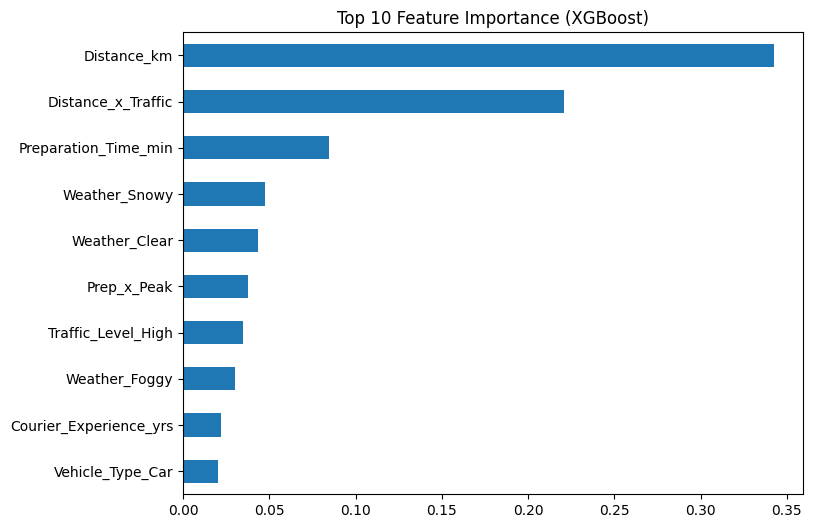

Distance_km               0.342301
Distance_x_Traffic        0.220910
Preparation_Time_min      0.084767
Weather_Snowy             0.047430
Weather_Clear             0.043688
Prep_x_Peak               0.037803
Traffic_Level_High        0.034849
Weather_Foggy             0.030358
Courier_Experience_yrs    0.021913
Vehicle_Type_Car          0.020192
Traffic_Level_Low         0.019516
Time_of_Day_Evening       0.017537
Weather_Windy             0.017180
Time_of_Day_Afternoon     0.014305
Vehicle_Type_Bike         0.012554
Weather_Rainy             0.011154
Traffic_Level_Medium      0.009654
Time_of_Day_Morning       0.007111
Time_of_Day_Night         0.006779
Is_Peak_Hour              0.000000
Vehicle_Type_Scooter      0.000000
dtype: float32


In [36]:
importances = pd.Series(
    best_xgb.feature_importances_,
    index=X_train_final.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importance (XGBoost)")
plt.gca().invert_yaxis()
plt.show()
print(importances)

# SHAP Analysis (Best Model)

## SHAP Explainer

In [34]:
explainer = shap.Explainer(best_xgb, X_train_final)
shap_values = explainer(X_test_final)

## SHAP Summary Plot

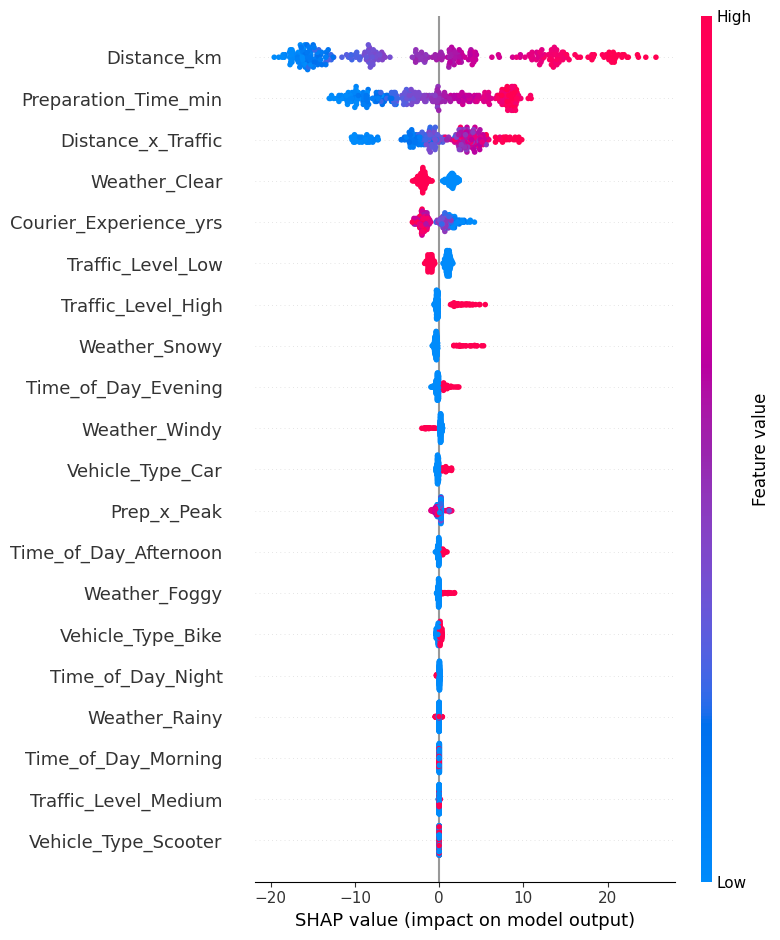

In [35]:
shap.summary_plot(shap_values, X_test_final)

In [39]:
print(shap_values)
print(X_test_final)

.values =
array([[-13.46565816,  -0.66117631,  -2.19475703, ...,   0.13633854,
         -0.1055223 ,   0.        ],
       [ -0.80672681,   8.04549145,   0.77698949, ...,   0.11574027,
         -0.19321425,   0.        ],
       [-13.17794599,  -3.07364248,  -2.25005278, ...,   0.30029986,
         -0.08440686,   0.        ],
       ...,
       [ -9.78911512, -11.11282429,  -0.14678315, ...,  -0.20833902,
         -0.10491804,   0.        ],
       [ 14.03116731,  -6.83927992,  -1.77188813, ...,  -0.03709255,
         -0.24612579,   0.        ],
       [ 12.16425676,  -3.61079663,   1.62096313, ...,  -0.04831238,
          1.45772322,   0.        ]], shape=(300, 21))

.base_values =
array([57.21855431, 57.21855431, 57.21855431, 57.21855431, 57.21855431,
       57.21855431, 57.21855431, 57.21855431, 57.21855431, 57.21855431,
       57.21855431, 57.21855431, 57.21855431, 57.21855431, 57.21855431,
       57.21855431, 57.21855431, 57.21855431, 57.21855431, 57.21855431,
       57.21855431, 

## SHAP Bar Plot

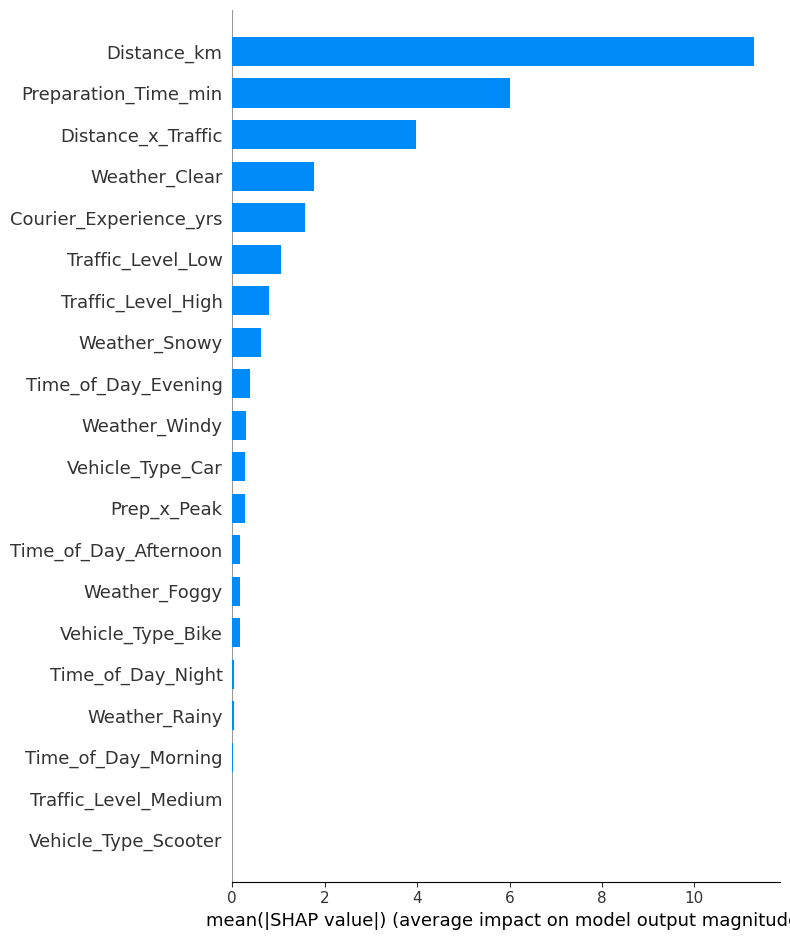

In [40]:
shap.summary_plot(shap_values, X_test_final, plot_type="bar")

In [61]:
features_to_plot = [
    "Distance_km",
    "Preparation_Time_min",
    "Weather_Clear"
]

<Figure size 1200x400 with 0 Axes>

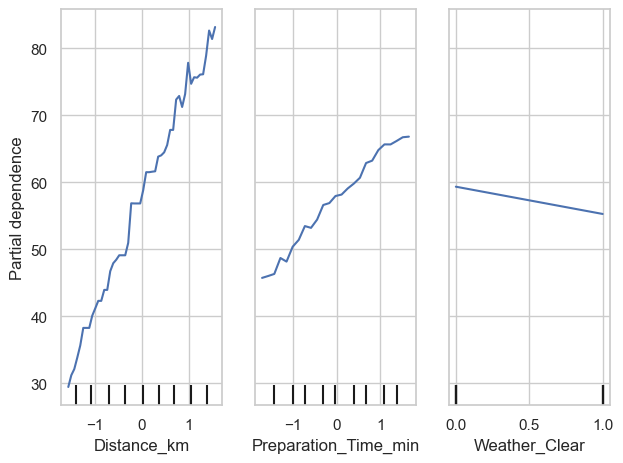

In [62]:
plt.figure(figsize=(12,4))

PartialDependenceDisplay.from_estimator(
    best_xgb,
    X_train_final,
    features=features_to_plot,
    kind="average",
    grid_resolution=50
)

plt.tight_layout()
plt.show()

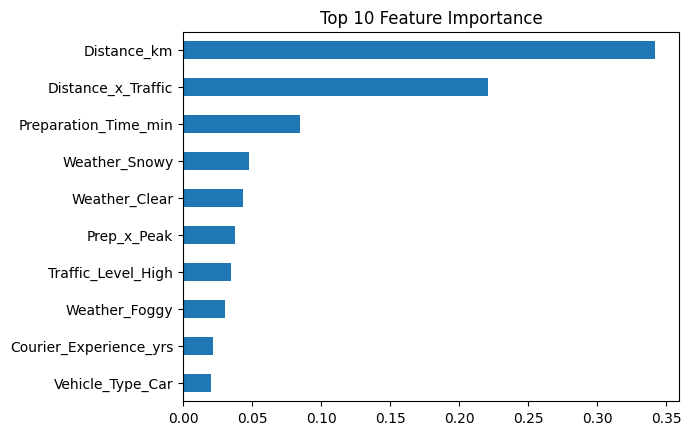

In [41]:
importances = pd.Series(best_xgb.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)
importances.head(10).plot(kind='barh', title='Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

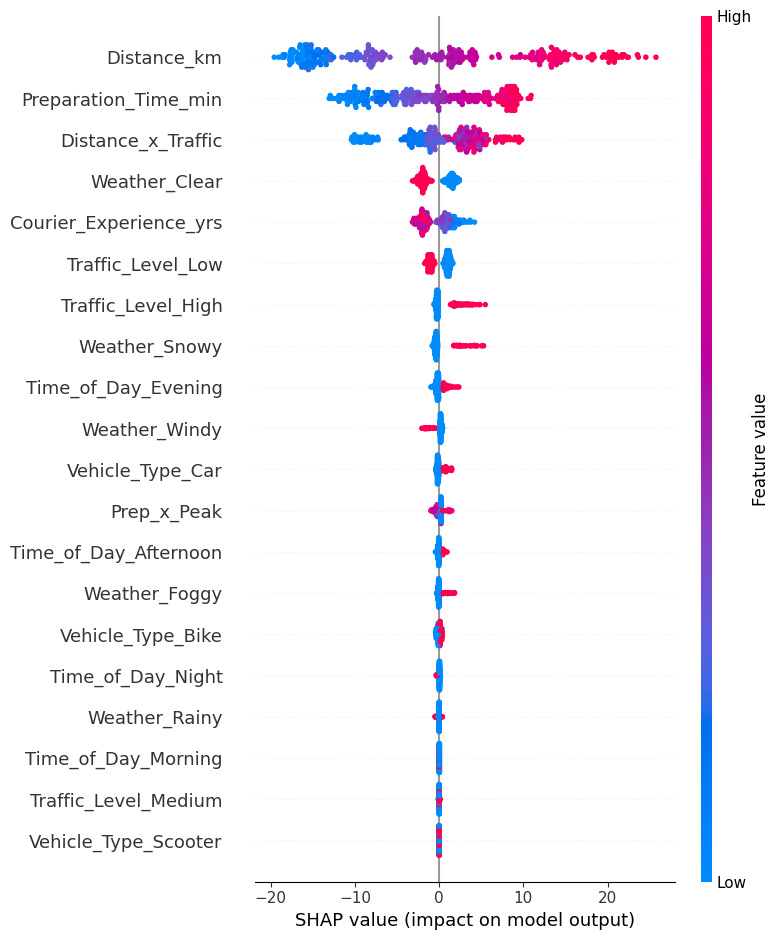

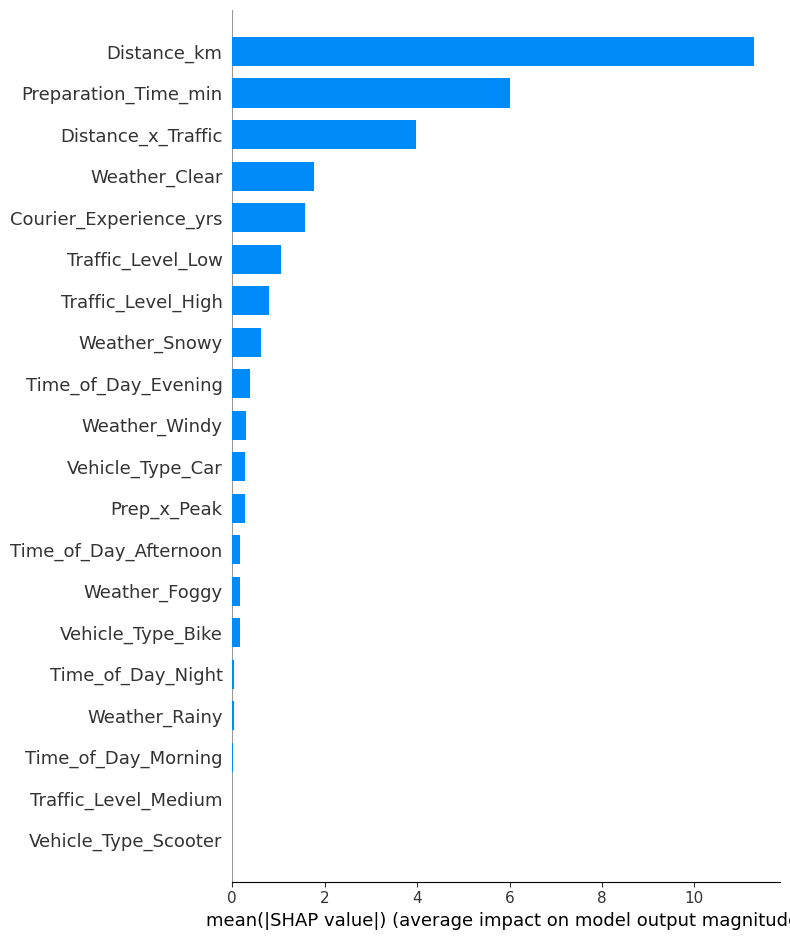

In [42]:
import shap
explainer = shap.Explainer(best_xgb, X_train_final)
shap_values = explainer(X_test_final)


shap.summary_plot(shap_values, X_test_final)
shap.summary_plot(shap_values, X_test_final, plot_type='bar')

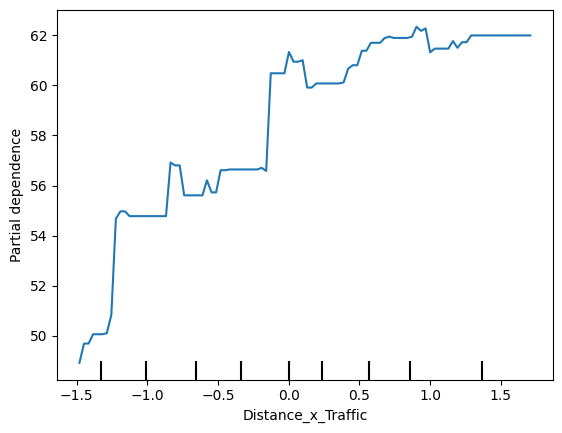

In [45]:
from sklearn.inspection import PartialDependenceDisplay


PartialDependenceDisplay.from_estimator(best_xgb, X_train_final, ['Distance_x_Traffic'])
plt.show()

In [46]:
print(best_xgb)
print(X_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=None, num_parallel_tree=None, ...)
     Distance_km  Preparation_Time_min  Courier_Experience_yrs  Is_Peak_Hour  \
541     1.079578             -0.724620               -1.250029      0.841021   
440    -0.439071             -1.144516               -0.905397      0.841021   
482     1.6268